Ce fichier est divisé en plusieurs sections. Il faut notamment faire attention au fait que dans un premier temps est implémenté un entraînement "classique", c'est-à-dire avec directement la fonction fit. Dans un second temps, est implémenté un entraînement à l'aide de générateurs afin de gérer de grosses bases de données. 

# Importations

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model as load_keras_model,Model,Sequential

In [2]:
import tensorflow.keras as keras

In [5]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [6]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input
from tensorflow.keras.activations import relu

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score,RocCurveDisplay,roc_curve, roc_auc_score

In [8]:
from aizynthfinder.chem import *
from aizynthfinder.utils import *
from aizynthfinder.training import *
from aizynthfinder.context import *

In [9]:
from aizynthfinder.utils.models import LocalKerasModel

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
from keras.utils.vis_utils import plot_model

In [12]:
import SelectionGroup

In [13]:
import tqdm.notebook as tqdm

In [14]:
from tensorflow.keras.optimizers import Adam

# Modeles

### Récupération du modèle d'aizynth et création d'un nouveau modèle

In [15]:
def create_model(loss_function="binary_crossentropy", 
                   optimizer="adam", metrics=['accuracy']):
    '''
    Fonction permettant de récupérer le modèle d'AizynthFinder et de le modifier pour le Transfer Learning
    '''
    
    #On récupère le modèle d'AizynthFinder
    model = LocalKerasModel("C:/Users/Yassine/Desktop/aizynth/uspto_filter_model.hdf5")
    
    #On gèle les paramètres
    model.model.trainable = False
    
    #Le modèle d'AF prenant deux inputs il faut concatener les branches de l'ancien modèle
    concat = tf.keras.layers.Concatenate()([model.model.layers[3].output,model.model.layers[4].output])
    
    #On rajoute deux nouveaux layers, un layer dense et un layer de sortie. 
    hidden1 = tf.keras.layers.Dense(1024,name = "Dense_3",activation = 'relu')(concat)
    layer_out = tf.keras.layers.Dense(1,name = "dense_5", activation = "sigmoid")(hidden1)
    
    #On créé notre nouveau modèle
    new_model = Model(inputs = [model.model.layers[0].input,model.model.layers[2].input],outputs = layer_out)
    
    #On enregistre le modèle sous forme de jpg à des fins d'illustration du rapport 
    plot_model(new_model, to_file='filter_model_plot.png', show_shapes=True, show_layer_names=True)
    
    #On compile le nouveau modèle
    new_model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])
    return new_model

### Setting Up Callbacks

#### Un callback est une fonction qui permet de modifier les hyperparamètres pendant  l'entraînement en fonction des mesures de précision à chaque epoch

In [18]:
#We set up a reducing learning rate call back
reduce_lr = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.8,
        patience=10,
        verbose=2,
        mode="auto",
        min_delta=0.0001,
        cooldown=0,
        min_lr=0,)

In [17]:
#We set up an early stopping callback
early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=25,
    verbose=2,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)


# Récupération des Datas 

In [19]:
fname_fp_false = "NOM DU FICHIER CONTENANT LES FAUSSES REACTIONS SUR LESQUELLES S'ENTRAINER"
fname_fp_true = "NOM DU FICHIER CONTENANT LES VRAIES  REACTIONS SUR LESQUELLES S'ENTRAINER"
fname_groups_false = "NOM DU FICHIER CONTENANT LES GROUPES DES FAUSSES REACTIONS"
fname_groups_true = "NOM DU FICHIER CONTENANT LES GROUPES DES VRAIES REACTIONS"


In [20]:
data_fp_false = pd.read_csv(fname_fp_false)
data_fp_true = pd.read_csv(fname_fp_true)
data_groups_false = pd.read_csv(fname_groups_false)
data_groups_true = pd.read_csv(fname_groups_true)

In [21]:
def fp_from_fp_db(fp_db):
    '''
    Cette fonction permet de recréer le fingerprint de taille 2048
    à partir du fingerprint codé en mémoire
    '''
    res = np.zeros(2048)
    #On initialise un array de 2048 zéros
    list_idx = fp_db.split(" ")
    #On récupère tous les indices non nuls du fingerprint
    for el in list_idx[:-1]:
        lfp = el.split("-")
        n = len(lfp)
        #En fonction des cas, on complète avec la bonne valeur
        if n == 1:
            res[int(lfp[0])] = 1
        elif n==2:
            res[int(lfp[0])] = int(lfp[-1])
        else:
            res[int(lfp[0])] = -int(lfp[-1])
    return res

def input_model_from_db(base_fp):
    '''
    Cette fonction renvoie un array de fingerprint à partir d'un dataset contenant des
    fingerprints sous forme "codée"
    '''
    #On sépare fingerprint de réactions et fingerprints du produit
    prod_fp_db,rxn_fp_db = base_fp["Product_Fingerprint"],base_fp["Reaction_Fingerprint"]
    prod_fp,rxn_fp = [],[]
    p_bar = tq.tqdm(total=base_fp.shape[0])
    for i in range(base_fp.shape[0]):
        #On essaie de récupérer le fingerprint associé à la ligne i
        try:
            p_bar.update(1)
            rxn_fp.append(fp_from_fp_db(rxn_fp_db.iloc[i]))
            prod_fp.append(fp_from_fp_db(prod_fp_db.iloc[i]))
        except:
            continue
    return np.array(prod_fp), np.array(rxn_fp)

In [22]:
def get_data(data_fp_false,data_fp_true,grps):
    '''
    Cette fonction permet de récupérer les data selon les grps sélectionnés
    '''
    res = []
    fp_grps = SelectionGroup.select_grp(data_fp_false,data_fp_true,grps)
    for prod_fp_false,rxn_fp_false,prod_fp_true,rxn_fp_true in fp_grps:
        prod_fp,rxn_fp = np.concatenate((prod_fp_false,prod_fp_true)),np.concatenate((rxn_fp_false,rxn_fp_true))
        labels = np.array([0]*prod_fp_false.shape[0]+[1]*prod_fp_true.shape[0])
        train_prop = 0.9
        test_prop  = 0.1
        assert(test_prop+train_prop==1)
        #On split ensuite aléatoirement la donnée en utilisant le random_state 42 pour avoir des résultats reproductibles
        res.append(train_test_split(prod_fp, rxn_fp, labels, train_size = train_prop, random_state=42))
    return res

## Dictionnary for group_correspondance

In [23]:
grp_correspondance = {"Aldehyde": "004",
         "Cetone":"005",
         "Enamine":"024",
         "Alcool":"028",
         "Phenol":"034",
         "Ether":"037",
         "Amine":"047",
         "Halogene":"061",
         "Acide Carboxylique":"076",
         "Lactone":"079",
         "Uree":"133",
         "Alcene":"199"}

In [24]:
#Reverse Dictionnary
reverse_grp_fp = {v: k for k, v in grp_correspondance.items()}

## Entrainement et premiers résultats

In [25]:
def plot_roc_curve_from_res(fpr,tpr,thresholds):
    '''
    Une fonction qui affiche la courbe ROC d'un modèle
    '''
    plt.plot(fpr,tpr)
    plt.xlabel("taux de faux positifs")
    plt.ylabel("taux de vrais positifs")
    plt.show()

In [27]:
def train_save_and_test_model(data_fp_false, data_fp_true, grps, nb_epochs=10, validation_split=0.1, 
                              shuffle=True, verbose=2, callbacks = [reduce_lr, early_stop],
                             loss_function="binary_crossentropy", optimizer="adam", metrics=['accuracy']):
    '''
    Une fonction qui entraîne et donne les premiers résultats sur un jeu de test créé dans la fonction
    '''
    
    #On récupère les données
    all_data = get_data(data_fp_false, data_fp_true, grps)[0]
    
    #On part du principe que l'on ne donne qu'un seul groupe
    prd_fp_train, prd_fp_test, rxn_fp_train, rxn_fp_test, labels_train, labels_test = all_data
    model = create_model(loss_function=loss_function, optimizer=optimizer, metrics=metrics)
    #On entraîne le modèle et on récupère les données au cours de l'entraînement
    history = model.fit(x = [rxn_fp_train, prd_fp_train],y = labels_train ,epochs = nb_epochs,verbose = verbose, shuffle=shuffle, 
                  validation_split = validation_split, callbacks = callbacks)
    
    #On récupère et affiche les scores sur le jeu de test créé
    scores = model.evaluate([rxn_fp_test, prd_fp_test], labels_test, verbose=verbose)
    print(f'Score : {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    labels_pred = model.predict([rxn_fp_test, prd_fp_test])
    labels_true = labels_test
    labels_pred_bin = [x > 0.5 for x in labels_pred]
    precision, recall, fscore, support = score(labels_true, labels_pred_bin, pos_label=1, average='binary')
    print(score(labels_true, labels_pred_bin, pos_label=1, average='binary'))
    fpr, tpr, thresholds = roc_curve(labels_true, labels_pred)
    plot_roc_curve_from_res(fpr,tpr,thresholds)
    print(roc_auc_score(labels_true, labels_pred))
    return model, history, precision, recall, fscore


In [29]:
#Ici, on teste nos fonctions avec le groupe Alcool
history = train_save_and_test_model(data_fp_false, data_fp_true, ['Alcool'], 40, validation_split=0.1, shuffle=True, verbose=2,
                         callbacks = [reduce_lr], loss_function="binary_crossentropy", 
                                    optimizer="adam", metrics = ['accuracy', 'mse'])[1]

['C:/Users/Yassine/Desktop/PSC/PSC_final/Data/False_reactions/Groups_False_Reactions/Alcool_False_Reactions.csv']


  0%|          | 0/46648 [00:00<?, ?it/s]

  0%|          | 0/223211 [00:00<?, ?it/s]

Epoch 1/40
6814/6814 - 52s - loss: 0.2590 - accuracy: 0.9066 - val_loss: 0.2161 - val_accuracy: 0.9211 - lr: 0.0010 - 52s/epoch - 8ms/step
Epoch 2/40
6814/6814 - 47s - loss: 0.2061 - accuracy: 0.9279 - val_loss: 0.1893 - val_accuracy: 0.9374 - lr: 0.0010 - 47s/epoch - 7ms/step
Epoch 3/40
6814/6814 - 48s - loss: 0.1856 - accuracy: 0.9366 - val_loss: 0.1784 - val_accuracy: 0.9399 - lr: 0.0010 - 48s/epoch - 7ms/step
Epoch 4/40
6814/6814 - 48s - loss: 0.1700 - accuracy: 0.9420 - val_loss: 0.1762 - val_accuracy: 0.9431 - lr: 0.0010 - 48s/epoch - 7ms/step
Epoch 5/40
6814/6814 - 47s - loss: 0.1585 - accuracy: 0.9461 - val_loss: 0.1742 - val_accuracy: 0.9425 - lr: 0.0010 - 47s/epoch - 7ms/step
Epoch 6/40
6814/6814 - 47s - loss: 0.1487 - accuracy: 0.9497 - val_loss: 0.1693 - val_accuracy: 0.9467 - lr: 0.0010 - 47s/epoch - 7ms/step
Epoch 7/40
6814/6814 - 47s - loss: 0.1418 - accuracy: 0.9525 - val_loss: 0.1745 - val_accuracy: 0.9450 - lr: 0.0010 - 47s/epoch - 7ms/step
Epoch 8/40
6814/6814 - 47s 

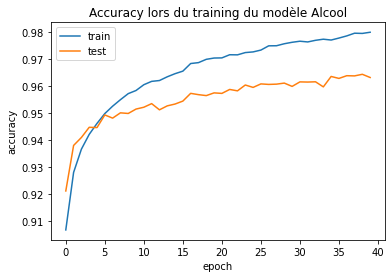

In [72]:
#On affiche la courbe de précision au cours de l'entraînement 
val_acc = history.history['val_accuracy']
plt.plot(history.history['accuracy'])
plt.plot(val_acc)
plt.title('Accuracy lors du training du modèle Alcool')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy_alcool_training.png')
plt.show()

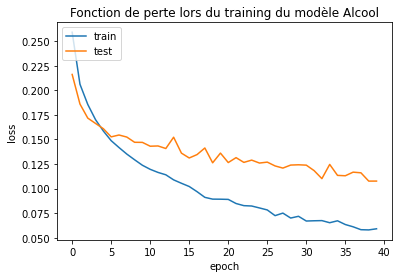

In [73]:
#On affiche la courbe de fonction de perte lors de l'entraînement du modèle
val_loss = history.history['val_loss']
plt.plot(history.history['loss'])
plt.plot(val_loss)
plt.title('Fonction de perte lors du training du modèle Alcool')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("Alcool_Loss_Training.png")
plt.show()

## Entraînement avec générateur

In [58]:
class DataGenerator(keras.utils.Sequence):
    #Générateur utilisé par Keras 
    def __init__(self, list_IDs, batch_size=256, shuffle=True, _filename_fp="",
                 _data_fp_true = None, _data_fp_false = None, _y_labels = None,  _grps = ['Alcool']):
        #Initialization
        
        self.batch_size = batch_size
        self.list_IDs = list_IDs        
        self.shuffle = shuffle
        
        #On initialise aussi une p_bar
        self.p_bar = tqdm.tqdm(total = self.__len__())
        
        self.grps = _grps        
        self.labels = _y_labels
        
        #Deux modes de chargement : soit on passe un nom de fichier, soit on passe directement une database
        if (_filename_fp != ""):
            self.filename_fp = _filename_fp
            self.data_fp = pd.read_csv(_filename_fp)
        
        else:
            self.data_fp_true  = _data_fp_true
            self.data_fp_false = _data_fp_false
            self.limit = _data_fp_true.shape[0]
        
        #On effectue un premier appel à la fonction self.on_epoch_end()
        self.on_epoch_end()

    def __len__(self):
        '''
        Calcule le nombre de batches par epoch
        '''
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        '''
        Générer un batch des donnnées
            '''
        
        # Genere indices du batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Liste des IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Genere la Data
        X, y = self.__data_generation(list_IDs_temp)
        
        #On update la Progress Bar
        self.p_bar.update(1)
        return X, y

    def on_epoch_end(self):
        '''
        Met à jour les indices après chaque epoch
        '''
        self.indexes = np.arange(len(self.list_IDs))
        #Si on choisit de shuffle
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        '''
        Generates data containing batch_size samples
        ''' 
        # Initialization
        X1 = []
        X2 = []
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i,val in enumerate(list_IDs_temp):
            val = int(val)
            #On distingue selon val pour savoir si c'est une vraie réaction ou une fausse réaction
            #Gain de temps considérable puisqu'on n'a pas besoin de passer en argument le tableau labels
            if (val >= self.limit):
                X1.append(fp_from_fp_db(self.data_fp_false.iloc[val-self.limit,1]))
                X2.append(fp_from_fp_db(self.data_fp_false.iloc[val-self.limit,2]))
                y[i] = 0
            else:
                X1.append(fp_from_fp_db(self.data_fp_true.iloc[val,1]))
                X2.append(fp_from_fp_db(self.data_fp_true.iloc[val,2]))
                y[i] = 1
            
        X1,X2 = np.array(X1), np.array(X2)
        return [X1,X2], y

In [45]:
path = "C:/Users/Yassine/Desktop/PSC/PSC_Final/Data/False_Reactions/"

In [55]:
s_fp = pd.read_csv(path + "All_False_Reactions_Shuffled_Fingerprints.csv")

In [43]:
def get_unvalid_index_true():
    return list(np.where(data_fp_true['Reaction_Fingerprint'].isna())[0])

In [42]:
def get_unvalid_index_false():
    return list(np.where(s_fp['Reaction_Fingerprint'].isna())[0])

In [41]:
def select_good_indices(grp):
    f_true = f"C:/Users/Yassine/Desktop/PSC/PSC_Final/Data/True_Reactions/Groups_True_Reactions/{grp}_True_Reactions.csv"
    indices_true = pd.read_csv(f_true).to_numpy().flatten()
    f_false = path + f"Groups_All_False_Reactions/{grp}_All_False_Reactions_Shuffled.csv"
    indices_false = pd.read_csv(f_false).to_numpy().flatten()
    return np.array(list(set(indices_true)-set(get_unvalid_index_true()))),np.array(list(set(indices_false)-set(get_unvalid_index_false()))) +data_fp_true.shape[0]

# Setting Up Callbacks

In [38]:
#We set up an early stopping callback
early_stop2 = EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=2,
    min_delta = 0.001,
    restore_best_weights=True
)


In [37]:
#We set up a reducing learning rate call back
reduce_lr2 = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.8,
        patience=5,
        verbose=2,
        mode="auto",
        min_delta=0.004,
        cooldown=0,
        min_lr=0,)

# Entrainement et Premiers Resultats

In [56]:
def train_save_and_test_model_generator(grp, nb_epochs=100, 
                              shuffle=True, verbose=2, callbacks = [reduce_lr2, early_stop2],
                             loss_function="binary_crossentropy", optimizer="adam", metrics=['accuracy']):
    ind_t, ind_f = select_good_indices(grp)
    n_t, n_f = ind_t.shape[0], ind_f.shape[0]
    ind = np.concatenate((ind_t, ind_f))
    labels = np.array([1]*n_t+[0]*n_f)
    ind_train, ind_test, labels_train, labels_test = train_test_split(ind, labels, random_state=42, train_size=0.8)
    #Un generateur d'entrainement et un generateur de validation
    training_generator = DataGenerator(ind_train, _data_fp_false = s_fp, _data_fp_true = data_fp_true, _y_labels = labels_train, shuffle=shuffle)
    validation_generator = DataGenerator(ind_test, _data_fp_false=s_fp, _data_fp_true = data_fp_true, _y_labels = labels_test, shuffle=shuffle)
    model = create_model()
    #On entraine le modele
    model.fit_generator(generator=training_generator,
                    use_multiprocessing=False,
                    verbose=2, 
                    initial_epoch=0,
                    validation_data = validation_generator,
                    max_queue_size=20,
                    epochs=nb_epochs,
                    callbacks = callbacks,
                    workers=20)
    #On sauve notre modele
    model.save(f"our_recommender_generator_{grp}")

In [63]:
train_save_and_test_model_generator("Halogene")

  0%|          | 0/3015 [00:00<?, ?it/s]

  0%|          | 0/753 [00:00<?, ?it/s]

<ipython-input-56-dc782d8f17b2>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=training_generator,


Epoch 1/100
3015/3015 - 146s - loss: 0.2689 - accuracy: 0.8997 - val_loss: 0.2265 - val_accuracy: 0.9171 - lr: 0.0010 - 146s/epoch - 48ms/step
Epoch 2/100
3015/3015 - 144s - loss: 0.2116 - accuracy: 0.9225 - val_loss: 0.2157 - val_accuracy: 0.9221 - lr: 0.0010 - 144s/epoch - 48ms/step
Epoch 3/100
3015/3015 - 144s - loss: 0.1858 - accuracy: 0.9322 - val_loss: 0.2042 - val_accuracy: 0.9264 - lr: 0.0010 - 144s/epoch - 48ms/step
Epoch 4/100
3015/3015 - 144s - loss: 0.1687 - accuracy: 0.9384 - val_loss: 0.2009 - val_accuracy: 0.9289 - lr: 0.0010 - 144s/epoch - 48ms/step
Epoch 5/100
3015/3015 - 143s - loss: 0.1569 - accuracy: 0.9428 - val_loss: 0.2029 - val_accuracy: 0.9280 - lr: 0.0010 - 143s/epoch - 47ms/step
Epoch 6/100
3015/3015 - 147s - loss: 0.1475 - accuracy: 0.9462 - val_loss: 0.2059 - val_accuracy: 0.9294 - lr: 0.0010 - 147s/epoch - 49ms/step
Epoch 7/100
3015/3015 - 144s - loss: 0.1405 - accuracy: 0.9486 - val_loss: 0.2066 - val_accuracy: 0.9288 - lr: 0.0010 - 144s/epoch - 48ms/step

In [ ]:
for x in ["Aldehyde","Cetone","Enamine", "Alcool", "Phenol", "Ether","Amine","Halogene",
          "Acide Carboxylique","Lactone","Uree","Alcene"]:
    train_save_and_test_model_generator(x)